<a href="https://colab.research.google.com/github/allenbao64/csc2515-project/blob/main/2515_Part_II_Saarthak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq transformers


     |████████████████████████████████| 1.4MB 7.8MB/s 
     |████████████████████████████████| 2.9MB 28.9MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 


In [1]:
import numpy as np
import pandas as pd
import random
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import tqdm.notebook as tq
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_json('../../../data/goodreads_books.json/goodreads_books.json', lines=True)
df.shape

In [ ]:
df.head()

In [ ]:
df[['description', 'book_id', 'title']].to_csv('../data/goodreads_book_info.csv', index=False)

In [ ]:
device

In [ ]:
df = pd.read_pickle('../data/goodreads.pkl')

In [ ]:
df

In [ ]:
df.iloc[0]['review_sentences']

In [ ]:
len(df)

In [ ]:
sent = []
spoil = []
for i in tq.tqdm(range(len(df))):
    for j in range(len(df.iloc[i]['review_sentences'])):
        sent.append(df.iloc[i]['review_sentences'][j][1])   
        spoil.append(df.iloc[i]['review_sentences'][j][0])

In [ ]:
df = pd.DataFrame(list(zip(sent, spoil)), 
               columns =['sentence', 'has_spoiler']) 

In [ ]:
df.to_pickle("../data/goodreads_sent_spoil.pkl")


In [2]:
df = pd.read_pickle("../data/goodreads_sent_spoil.pkl")

In [3]:
df.head()

,sentence,has_spoiler
0,Essential reading for anyone serious about mys...,0
1,Hammett is the grandfather of the hard-bitten ...,0
2,While his Continental Op was the prototype for...,0
3,"Expect sharp dialog, vivid characters and a vo...",0
4,If you've seen John Huston's 1941 film version...,0


In [4]:
df.has_spoiler.value_counts()

0    3419580
1     114754
Name: has_spoiler, dtype: int64

In [5]:
df = pd.concat([df[df.has_spoiler==1], df[df.has_spoiler==0].sample(len(df[df.has_spoiler==1]))]).sample(frac=1)

In [6]:
#df = df.sample(frac=0.1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229508 entries, 209171 to 1162970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sentence     229508 non-null  object
 1   has_spoiler  229508 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ MB


In [4]:
class_names = ['no_spoilers', 'has_spoilers']

C:\Users\wojtek\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'no_spoilers'), Text(1, 0, 'has_spoilers')]

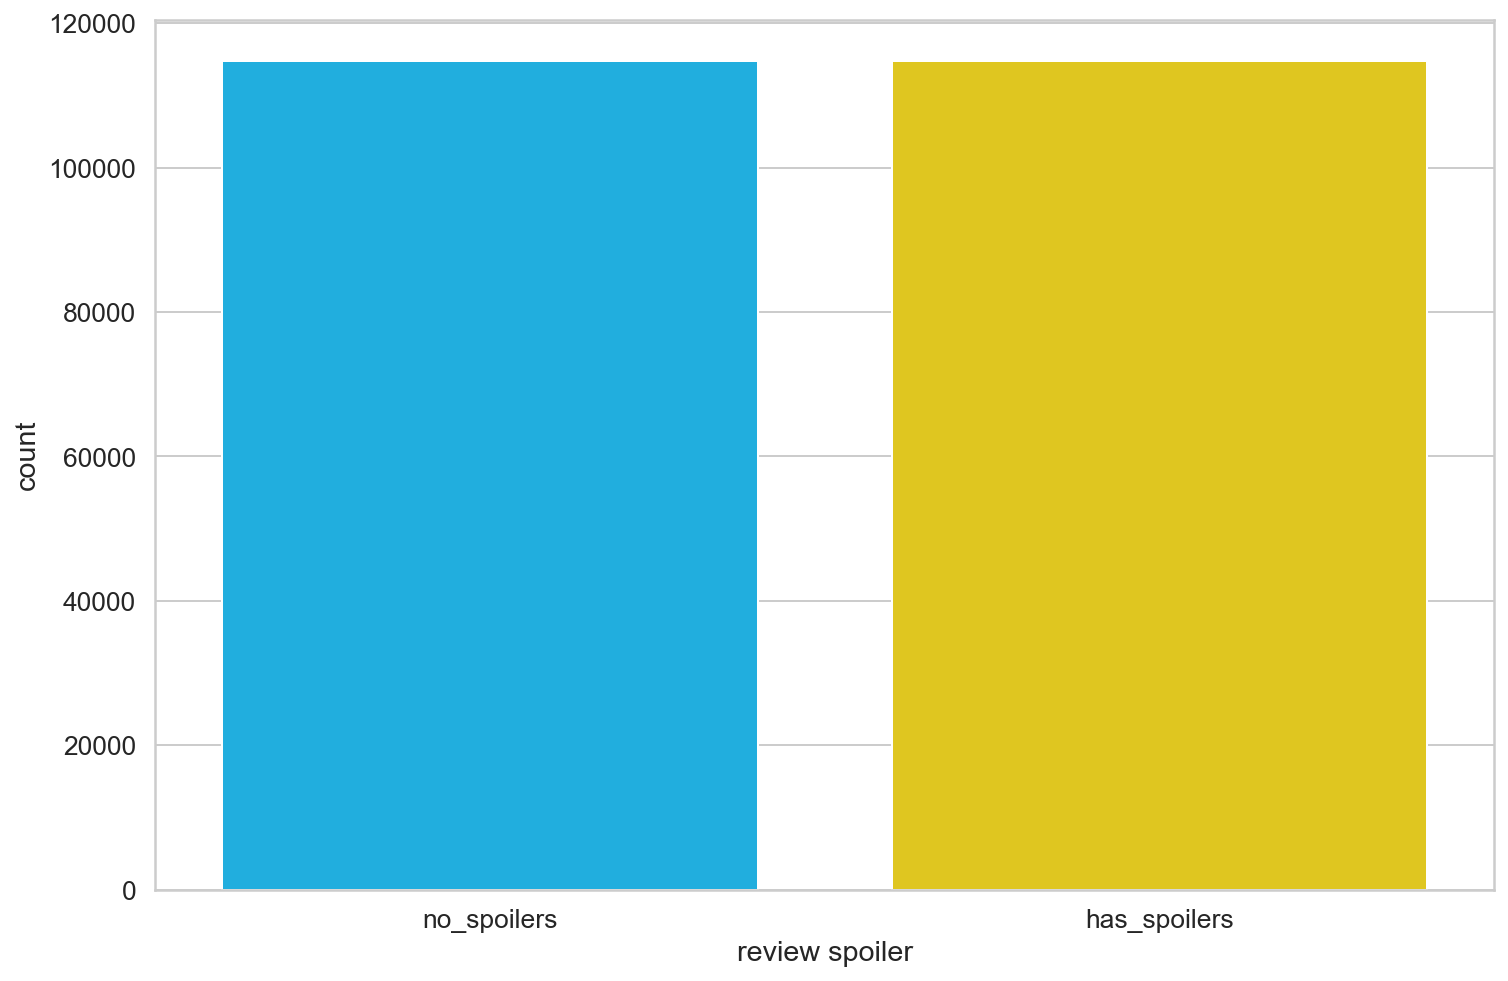

In [9]:
ax = sns.countplot(df.has_spoiler)
plt.xlabel('review spoiler')
ax.set_xticklabels(class_names)

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [12]:
token_lens = []
for txt in tq.tqdm(df.sentence):
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

  0%|          | 0/229508 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


C:\Users\wojtek\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


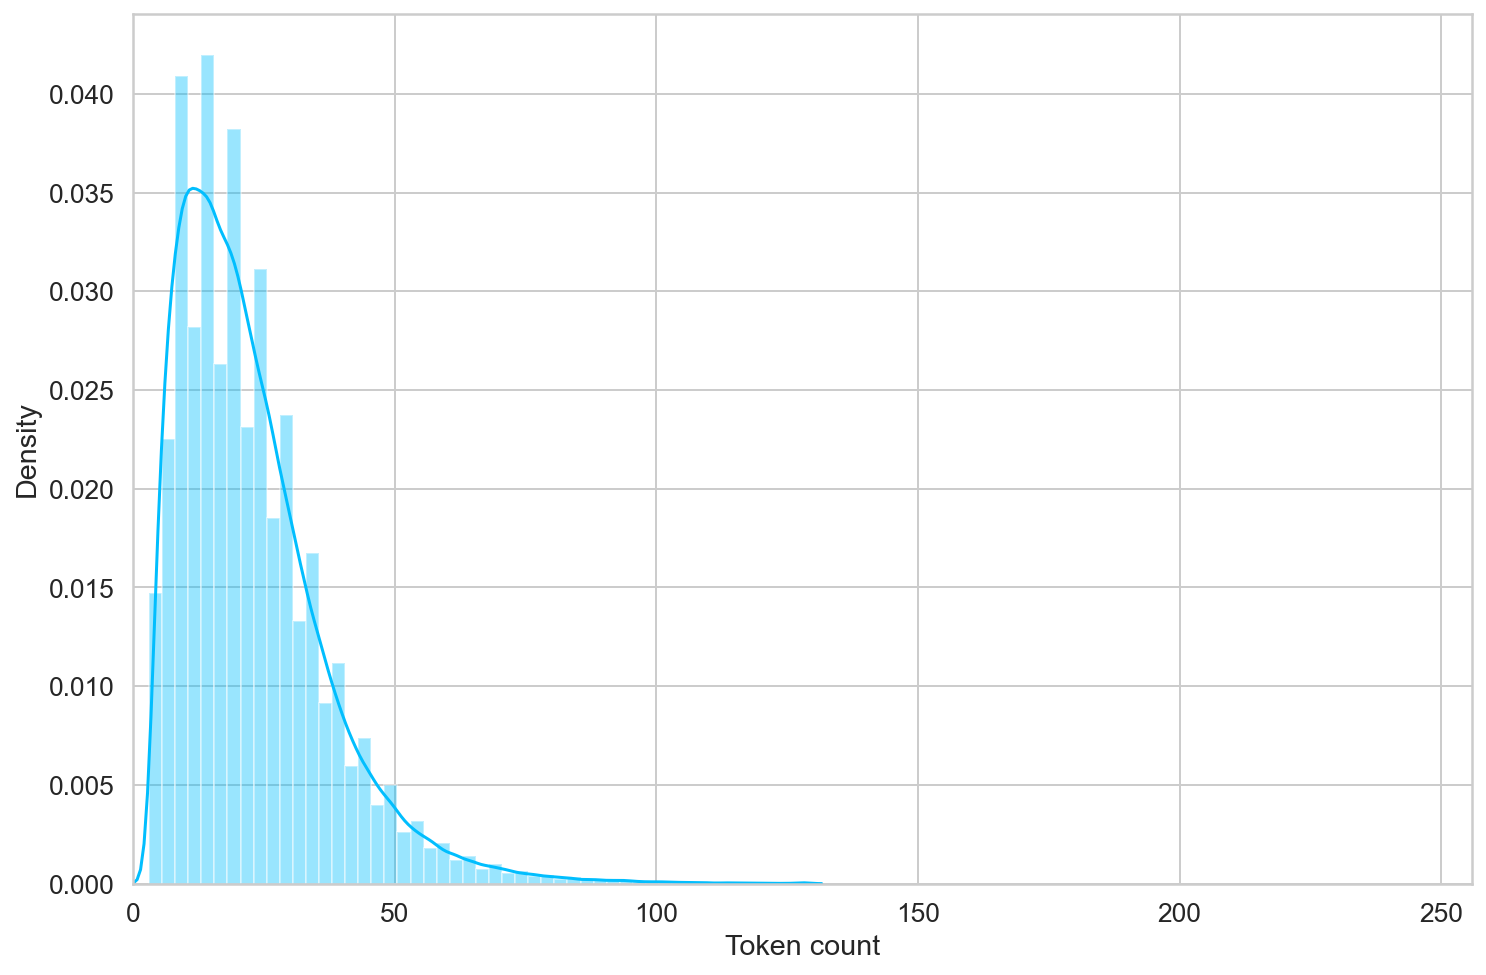

In [13]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [12]:
MAX_LEN = 128

In [15]:
class GPReviewDataset(Dataset):
  
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [16]:
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [17]:
df_train.shape, df_val.shape, df_test.shape

((183606, 2), (22951, 2), (22951, 2))

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.sentence.to_numpy(),
    targets=df.has_spoiler.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True
  )

In [13]:
BATCH_SIZE = 32

In [20]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
import warnings
warnings.filterwarnings('ignore')
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [22]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [14]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
class SpoilerClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpoilerClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        ).to_tuple()
        output = self.drop(pooled_output)
        return self.out(output)

In [16]:
model = SpoilerClassifier(len(class_names))
model = model.to(device)

In [26]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [27]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [20]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [29]:
from time import time

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  avg_losses = []
  aurocs = []
  avg_aurocs = []
  correct_predictions = 0
  i = 0
  t0 = time()
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    aurocs.append(roc_auc_score(targets.cpu(), preds.cpu()))
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    i += 1
    if i % 100 == 0:
        avg_aurocs.append(np.mean(aurocs[i-100:i]))
        avg_losses.append(np.mean(losses[i-100:i]))
        print(i, 'iters, auroc, loss, time : ', avg_aurocs[-1], avg_losses[-1], time()-t0)
  return correct_predictions.double() / n_examples, np.mean(losses), avg_losses, avg_aurocs

In [30]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  aurocs = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      aurocs.append(roc_auc_score(targets.cpu(), preds.cpu()))
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses), np.mean(aurocs)

In [31]:
%%time
history = defaultdict(list)
best_auroc = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss, train_avg_losses, train_auroc = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}  auroc {np.mean(train_auroc)}')
  val_acc, val_loss, val_auroc = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc} auroc {val_auroc}')
  print()
  history['train_auroc'] += train_auroc
  history['train_loss'] += train_avg_losses
  history['val_auroc'].append(val_auroc)
  history['val_loss'].append(val_loss)
  if val_auroc > best_auroc:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_auroc = val_auroc

Epoch 1/5
----------
100 iters, auroc, loss, time :  0.6362408696609548 0.6445195198059082 23.70180106163025
200 iters, auroc, loss, time :  0.6718320818328558 0.5984723061323166 47.54485750198364
300 iters, auroc, loss, time :  0.6917164254210963 0.5779154843091965 71.46735572814941
400 iters, auroc, loss, time :  0.6987139463442213 0.568822072148323 95.44645738601685
500 iters, auroc, loss, time :  0.7026419518117425 0.5802786248922348 119.48461556434631
600 iters, auroc, loss, time :  0.7142699925977015 0.5500110810995102 143.62596035003662
700 iters, auroc, loss, time :  0.694036121625417 0.5597801405191422 167.76299810409546
800 iters, auroc, loss, time :  0.7058721265386025 0.5634134244918824 191.83352756500244
900 iters, auroc, loss, time :  0.7109728417446735 0.556369760632515 216.01358723640442
1000 iters, auroc, loss, time :  0.7029762819692909 0.5667268517613411 240.4426851272583
1100 iters, auroc, loss, time :  0.7136739495716142 0.56570321559906 264.6937475204468
1200 iter

3400 iters, auroc, loss, time :  0.789337183241595 0.44700423911213877 826.3922114372253
3500 iters, auroc, loss, time :  0.792046920915342 0.4392546325922012 850.6519017219543
3600 iters, auroc, loss, time :  0.7897493626813354 0.4443169668316841 874.9216685295105
3700 iters, auroc, loss, time :  0.7892837149838091 0.44434913277626037 899.2158601284027
3800 iters, auroc, loss, time :  0.7941727361429122 0.4430193680524826 923.5048089027405
3900 iters, auroc, loss, time :  0.7982973590400566 0.4279423114657402 947.8368897438049
4000 iters, auroc, loss, time :  0.7887157745692036 0.4511014588177204 972.1850838661194
4100 iters, auroc, loss, time :  0.791278995829928 0.4527839061617851 996.4617671966553
4200 iters, auroc, loss, time :  0.7942624918632539 0.43866207838058474 1020.7235910892487
4300 iters, auroc, loss, time :  0.7962703508371497 0.45203960955142974 1044.9712784290314
4400 iters, auroc, loss, time :  0.8021288763116904 0.4297547933459282 1069.2884876728058
4500 iters, auroc

800 iters, auroc, loss, time :  0.9054246184242315 0.23809911094605923 194.5567111968994
900 iters, auroc, loss, time :  0.8923938405029483 0.2611453126370907 218.8549599647522
1000 iters, auroc, loss, time :  0.9004751501583176 0.2494099060446024 243.12630534172058
1100 iters, auroc, loss, time :  0.9046052145953464 0.2402347845584154 267.4646987915039
1200 iters, auroc, loss, time :  0.8951376567822407 0.2630059416592121 291.8275821208954
1300 iters, auroc, loss, time :  0.9056358296220242 0.22750713676214218 316.1651678085327
1400 iters, auroc, loss, time :  0.9001351517849194 0.2527495381236076 340.4650127887726
1500 iters, auroc, loss, time :  0.8939612803720859 0.2617712942510843 364.78928899765015
1600 iters, auroc, loss, time :  0.8978211017718019 0.24617128312587738 389.129163980484
1700 iters, auroc, loss, time :  0.9028475247251664 0.2360195254534483 413.40652084350586
1800 iters, auroc, loss, time :  0.901586936383763 0.24622759837657213 437.71038603782654
1900 iters, auroc

4100 iters, auroc, loss, time :  0.9257454965634566 0.1959795357659459 999.7697489261627
4200 iters, auroc, loss, time :  0.9261748029017766 0.19347212564200164 1024.1070861816406
4300 iters, auroc, loss, time :  0.9165505373227526 0.20735518250614404 1048.4070119857788
4400 iters, auroc, loss, time :  0.9312868015913683 0.17616182949393988 1072.6816685199738
4500 iters, auroc, loss, time :  0.921107262173671 0.20105391543358564 1096.9475877285004
4600 iters, auroc, loss, time :  0.9181046756475227 0.20446443881839513 1121.2730252742767
4700 iters, auroc, loss, time :  0.9157876717804787 0.19885097965598106 1145.5389547348022
4800 iters, auroc, loss, time :  0.9199750575576813 0.20017506755888462 1169.8428814411163
4900 iters, auroc, loss, time :  0.9302087456037179 0.18572551187127828 1194.10880112648
5000 iters, auroc, loss, time :  0.9207281994106684 0.1988472449965775 1218.3987247943878
5100 iters, auroc, loss, time :  0.9186831912432178 0.19370947699993848 1242.7346606254578
5200 

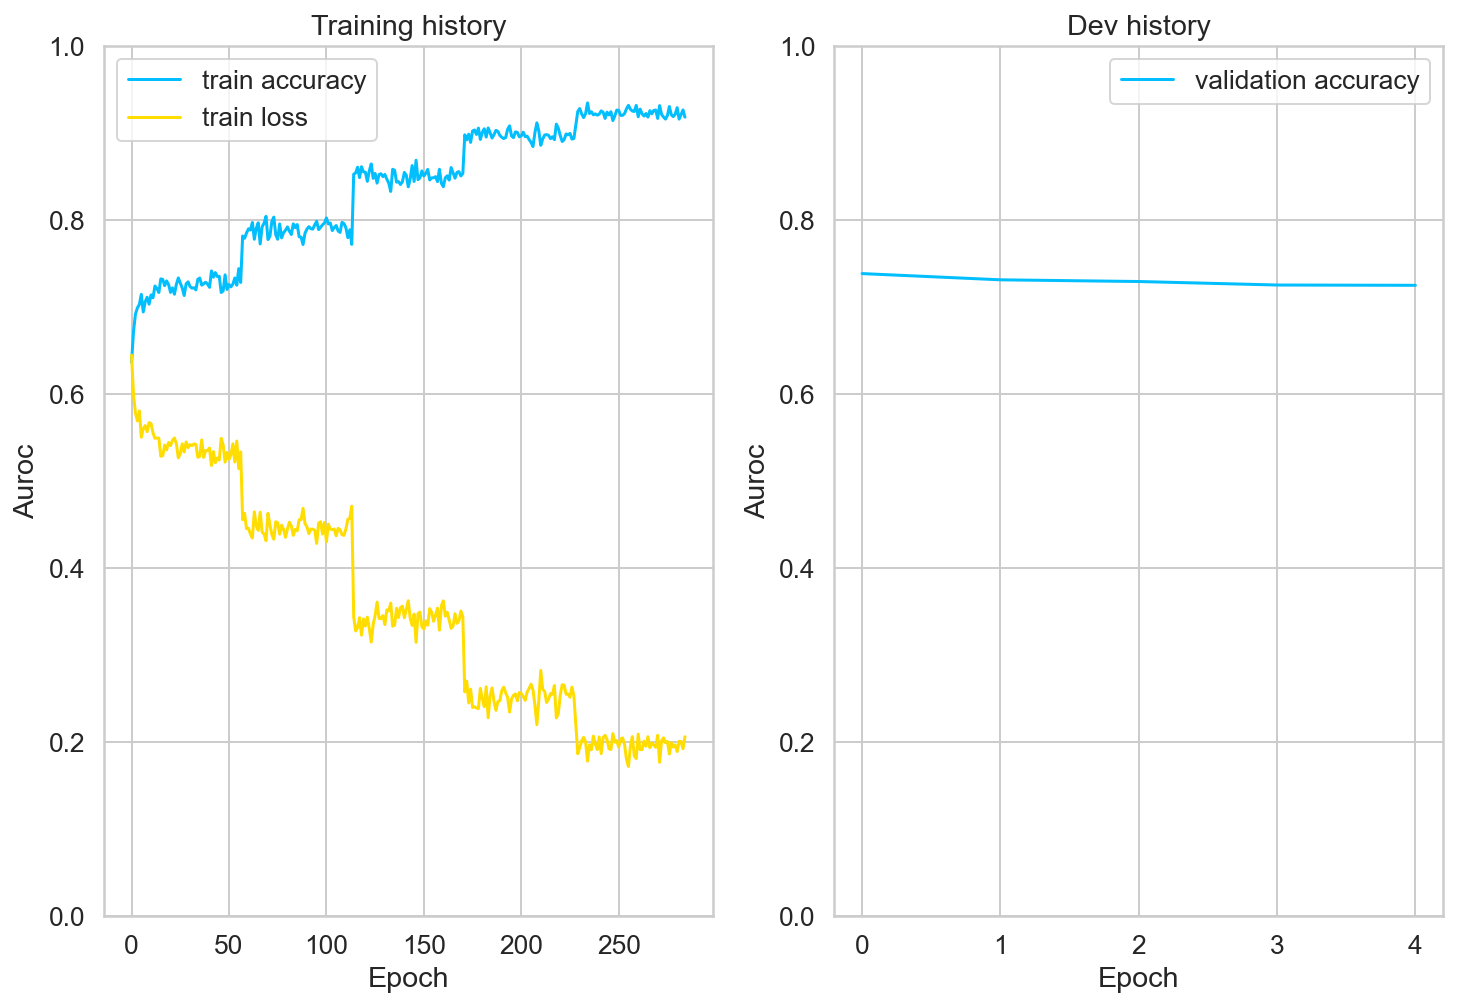

In [32]:
plt.subplot(1,2,1)
plt.plot(history['train_auroc'], label='train accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.title('Training history')
plt.ylabel('Auroc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.subplot(1,2,2)
plt.plot(history['val_auroc'], label='validation accuracy')
plt.title('Dev history')
plt.ylabel('Auroc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [40]:
 torch.save(model.state_dict(), 'bert_undersample_5ep.bin')

In [33]:
test_acc, _, test_auc = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item(), test_auc.item()

(16.2608165221559, 0.7219385412809287)

In [50]:
test_df = pd.read_pickle('../data/flattened_15K_test.pkl')
test_df = test_df[['sentence', 'sent_spoil']]
test_df.columns = ['sentence', 'has_spoiler']
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [51]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [52]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [53]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

 no_spoilers       0.99      0.73      0.84     14485
has_spoilers       0.10      0.89      0.19       516

    accuracy                           0.73     15001
   macro avg       0.55      0.81      0.51     15001
weighted avg       0.96      0.73      0.82     15001



In [54]:
print(roc_auc_score(y_test, y_pred))


0.8074184601552529


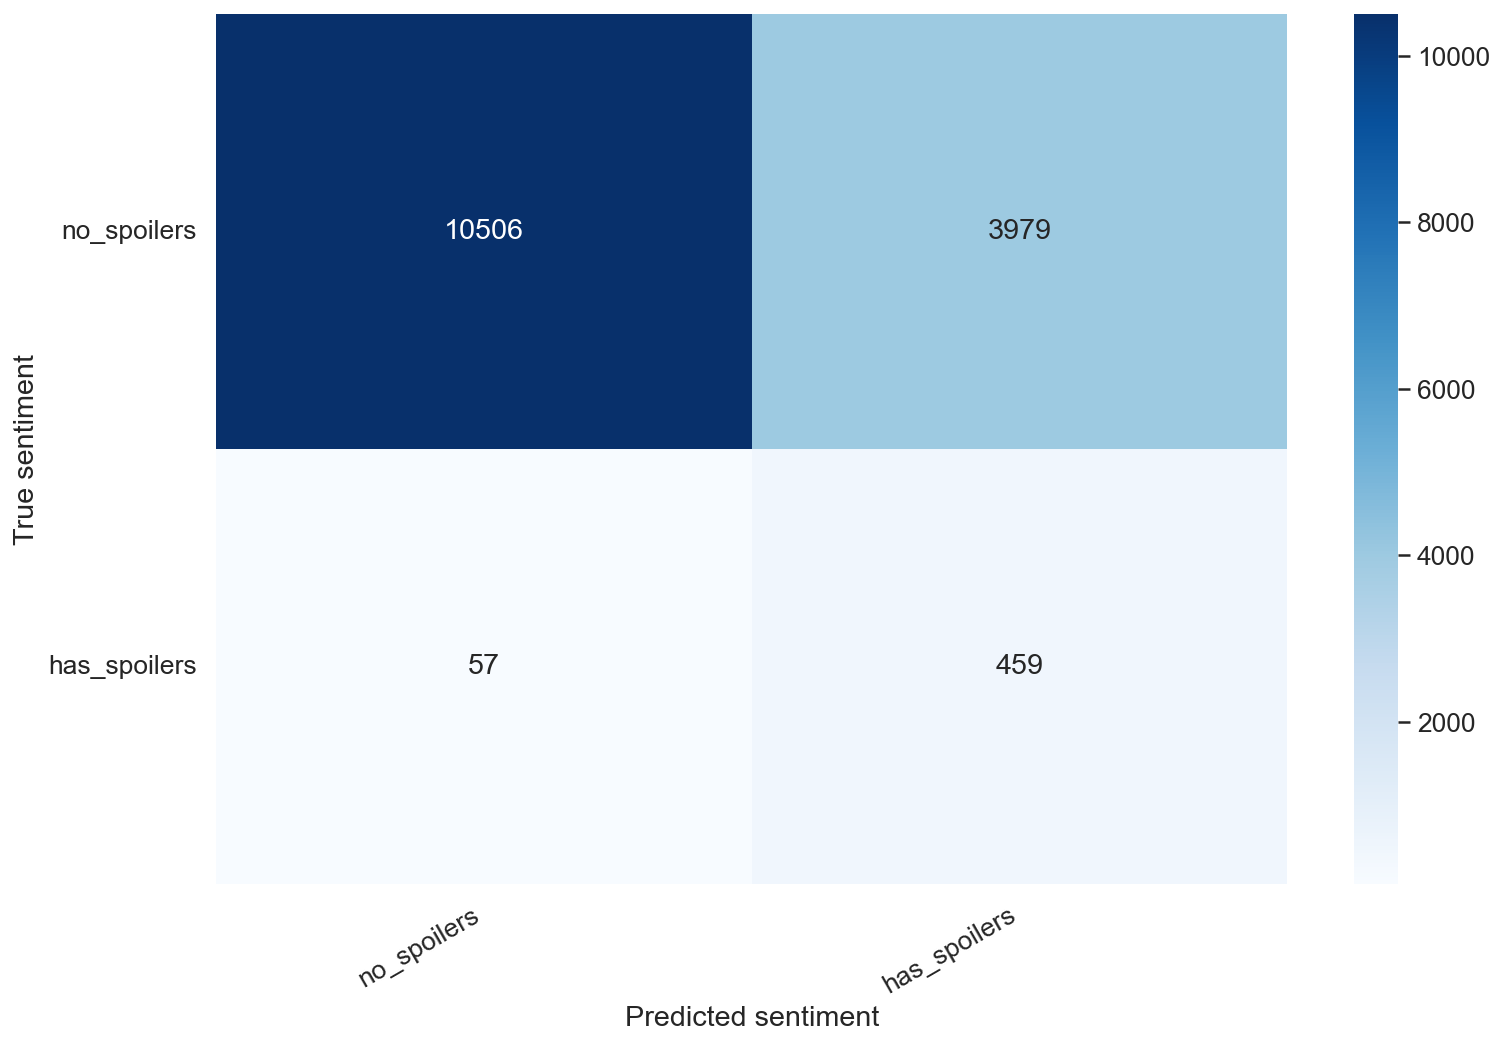

In [55]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [36]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [37]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Wow, this book was incredible, possibly a 4.5 or 5, haven't quite
decided yet.

True sentiment: no_spoilers


(0.0, 1.0)

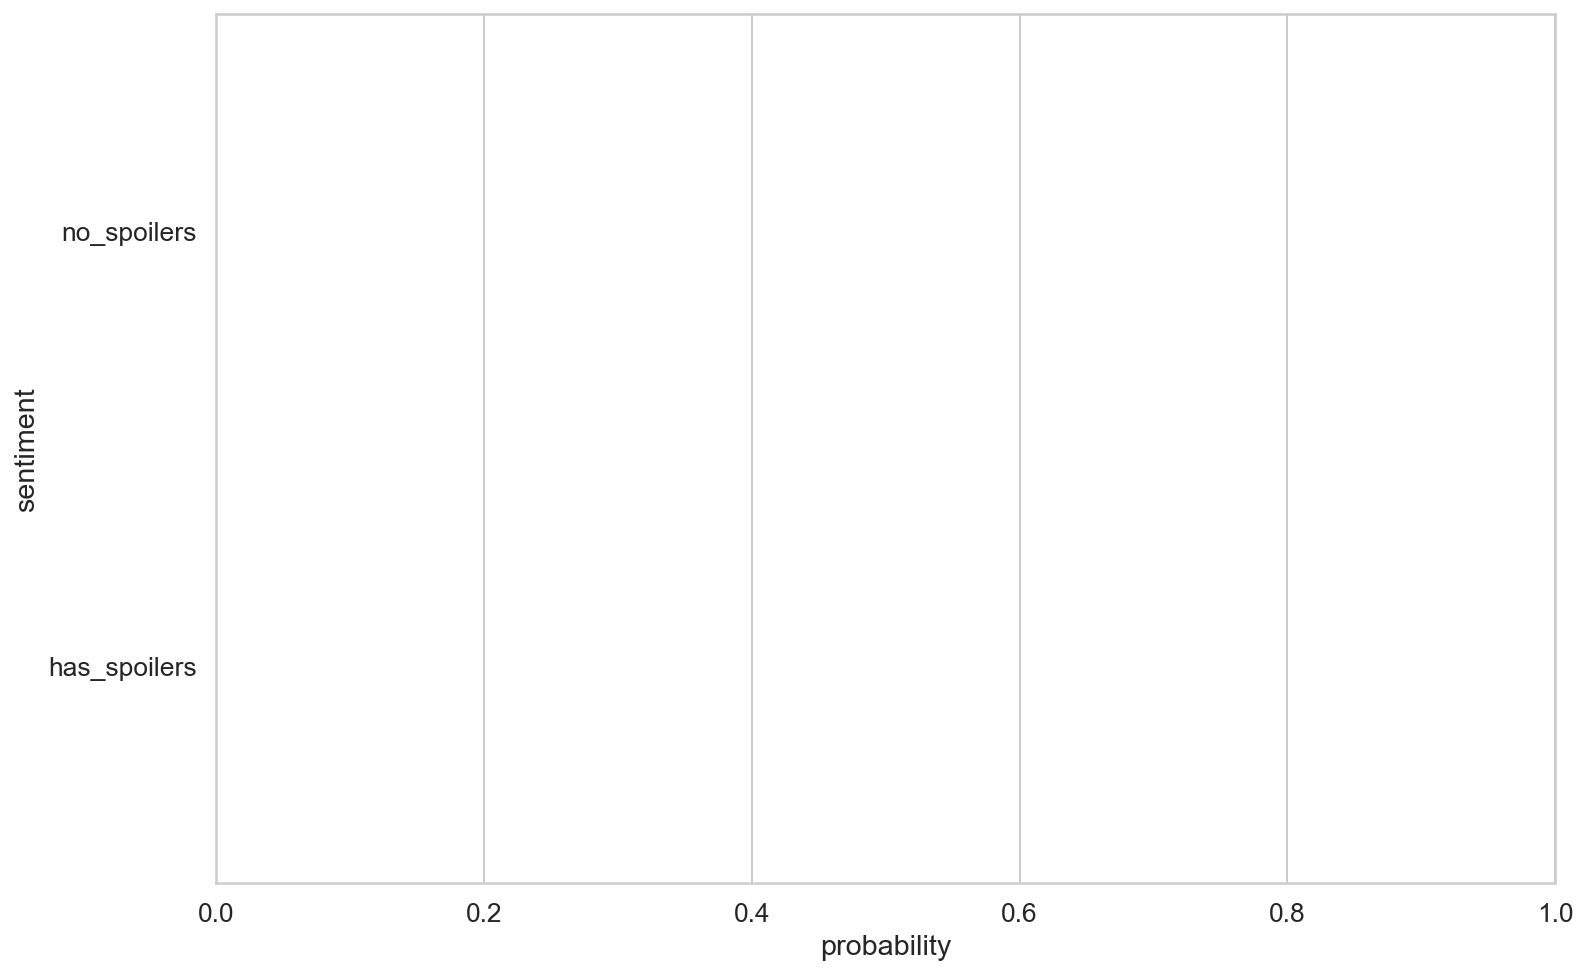

In [38]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

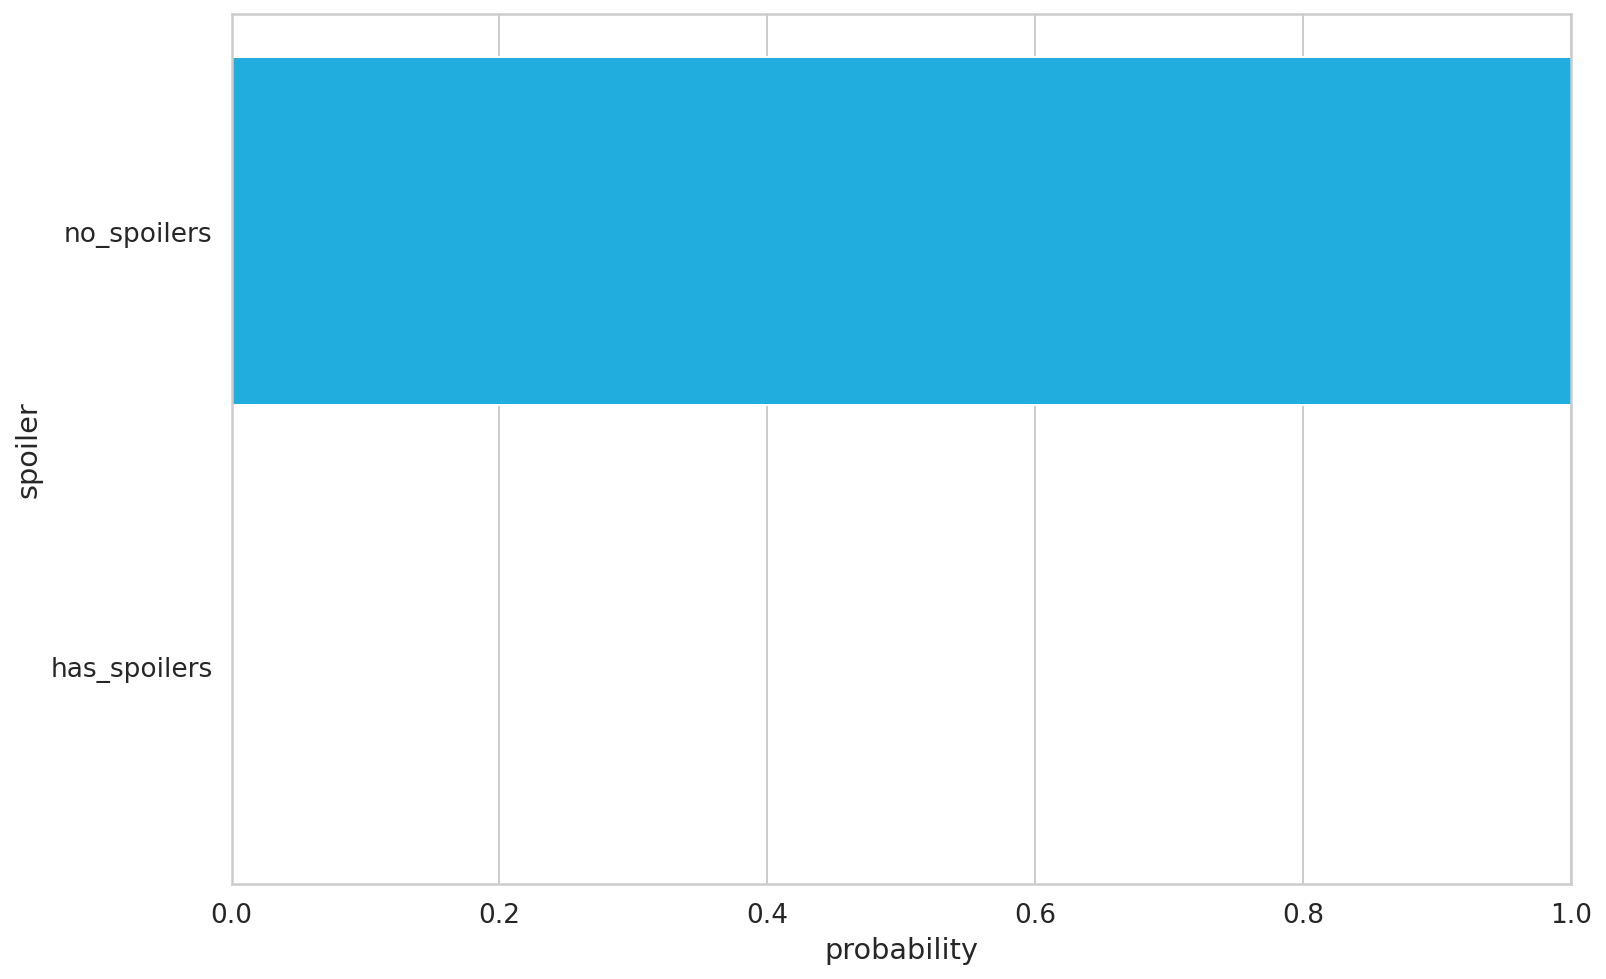

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('spoiler')
plt.xlabel('probability')
plt.xlim([0, 1]);